# PyMC-Marketing MMM

Relevant imports

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.prior import Prior

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

Loading the data

In [2]:
data = pd.read_csv("model_data.csv", parse_dates=["date_week"])

In [3]:
mmm = MMM(
    date_column="date_week",
    channel_columns=["x1", "x2", 'x3', 'x4'],
    adstock=GeometricAdstock(l_max=12),
    saturation=LogisticSaturation(),
    control_columns=['c1', 'c2', 'c3'],
    yearly_seasonality=2,
)

## Model Specification

This is a national model with the following specification:

$$
y_{t} = \mu + \sum_{i=0}^{4} \gamma^{[F]}_{i} f_{t,i} 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{i} z_{t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{i} \text{LogisticAdstock} \left( \{ x^{[M]}_{t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_i \right) + \epsilon_{t}
$$

Where:

- $\mu$ represents the intercept.
- $\sum_{i=0}^{4} \gamma^{[F]}_{i} f_{t,i}$ represents the seasonality/fourier contribution (order 2).
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{i} z_{t,i}$ represents the control contribution.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{i} \text{LogisticAdstock} \left( \{ x^{[M]}_{t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_i \right)$ represents the adstocked saturated media contribution.

**Note** This default configuration has been used:

- $\mu \sim $ Normal(0,2)
- $\beta^{[M]}_i \sim $ HalfNormal(2)
- $\gamma^{[C]} \sim $ Normal(0,2)
- $\gamma^{[F]} \sim $ Laplace(0,1)
- $\alpha^{[M]} \sim $ Beta(1,3)
- $\lambda^{[M]} \sim $ Gamma(3,1)
- $\sigma \sim $ HalfNormal(2) 

In [4]:
X = data.drop("y", axis=1)
y = data["y"]

In [5]:
mmm.fit(X=X, y=y, chains=4, target_accept=0.85, nuts_sampler="numpyro", random_seed=rng)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [6]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

0

In [7]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.178,0.012,0.153,0.200,0.000,0.000,2233.0,2388.0,1.0
y_sigma,0.025,0.001,0.022,0.028,0.000,0.000,3323.0,2498.0,1.0
saturation_beta[x1],0.395,0.290,0.153,0.855,0.009,0.006,1515.0,1271.0,1.0
saturation_beta[x2],0.936,0.517,0.359,1.844,0.014,0.010,1708.0,1895.0,1.0
saturation_beta[x3],0.365,0.015,0.340,0.394,0.000,0.000,1903.0,2189.0,1.0
saturation_beta[x4],0.222,0.232,0.049,0.537,0.006,0.004,1617.0,1856.0,1.0
saturation_lam[x1],1.657,0.774,0.283,2.986,0.019,0.014,1460.0,1368.0,1.0
saturation_lam[x2],1.014,0.427,0.276,1.784,0.010,0.007,1633.0,1840.0,1.0
saturation_lam[x3],3.189,0.247,2.716,3.648,0.006,0.004,2021.0,2072.0,1.0
saturation_lam[x4],2.315,1.400,0.145,4.741,0.031,0.022,1729.0,1757.0,1.0


In [8]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 6MB
Dimensions:  (sample: 4000, date: 174)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2022-01-03 2022-01-10 ... 2025-04-28
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 6MB 2.657 2.952 2.834 ... 6.207 6.421 6.519
Attributes:
    created_at:                 2025-04-28T12:25:39.919979+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.21.1

### Parameter Recovery

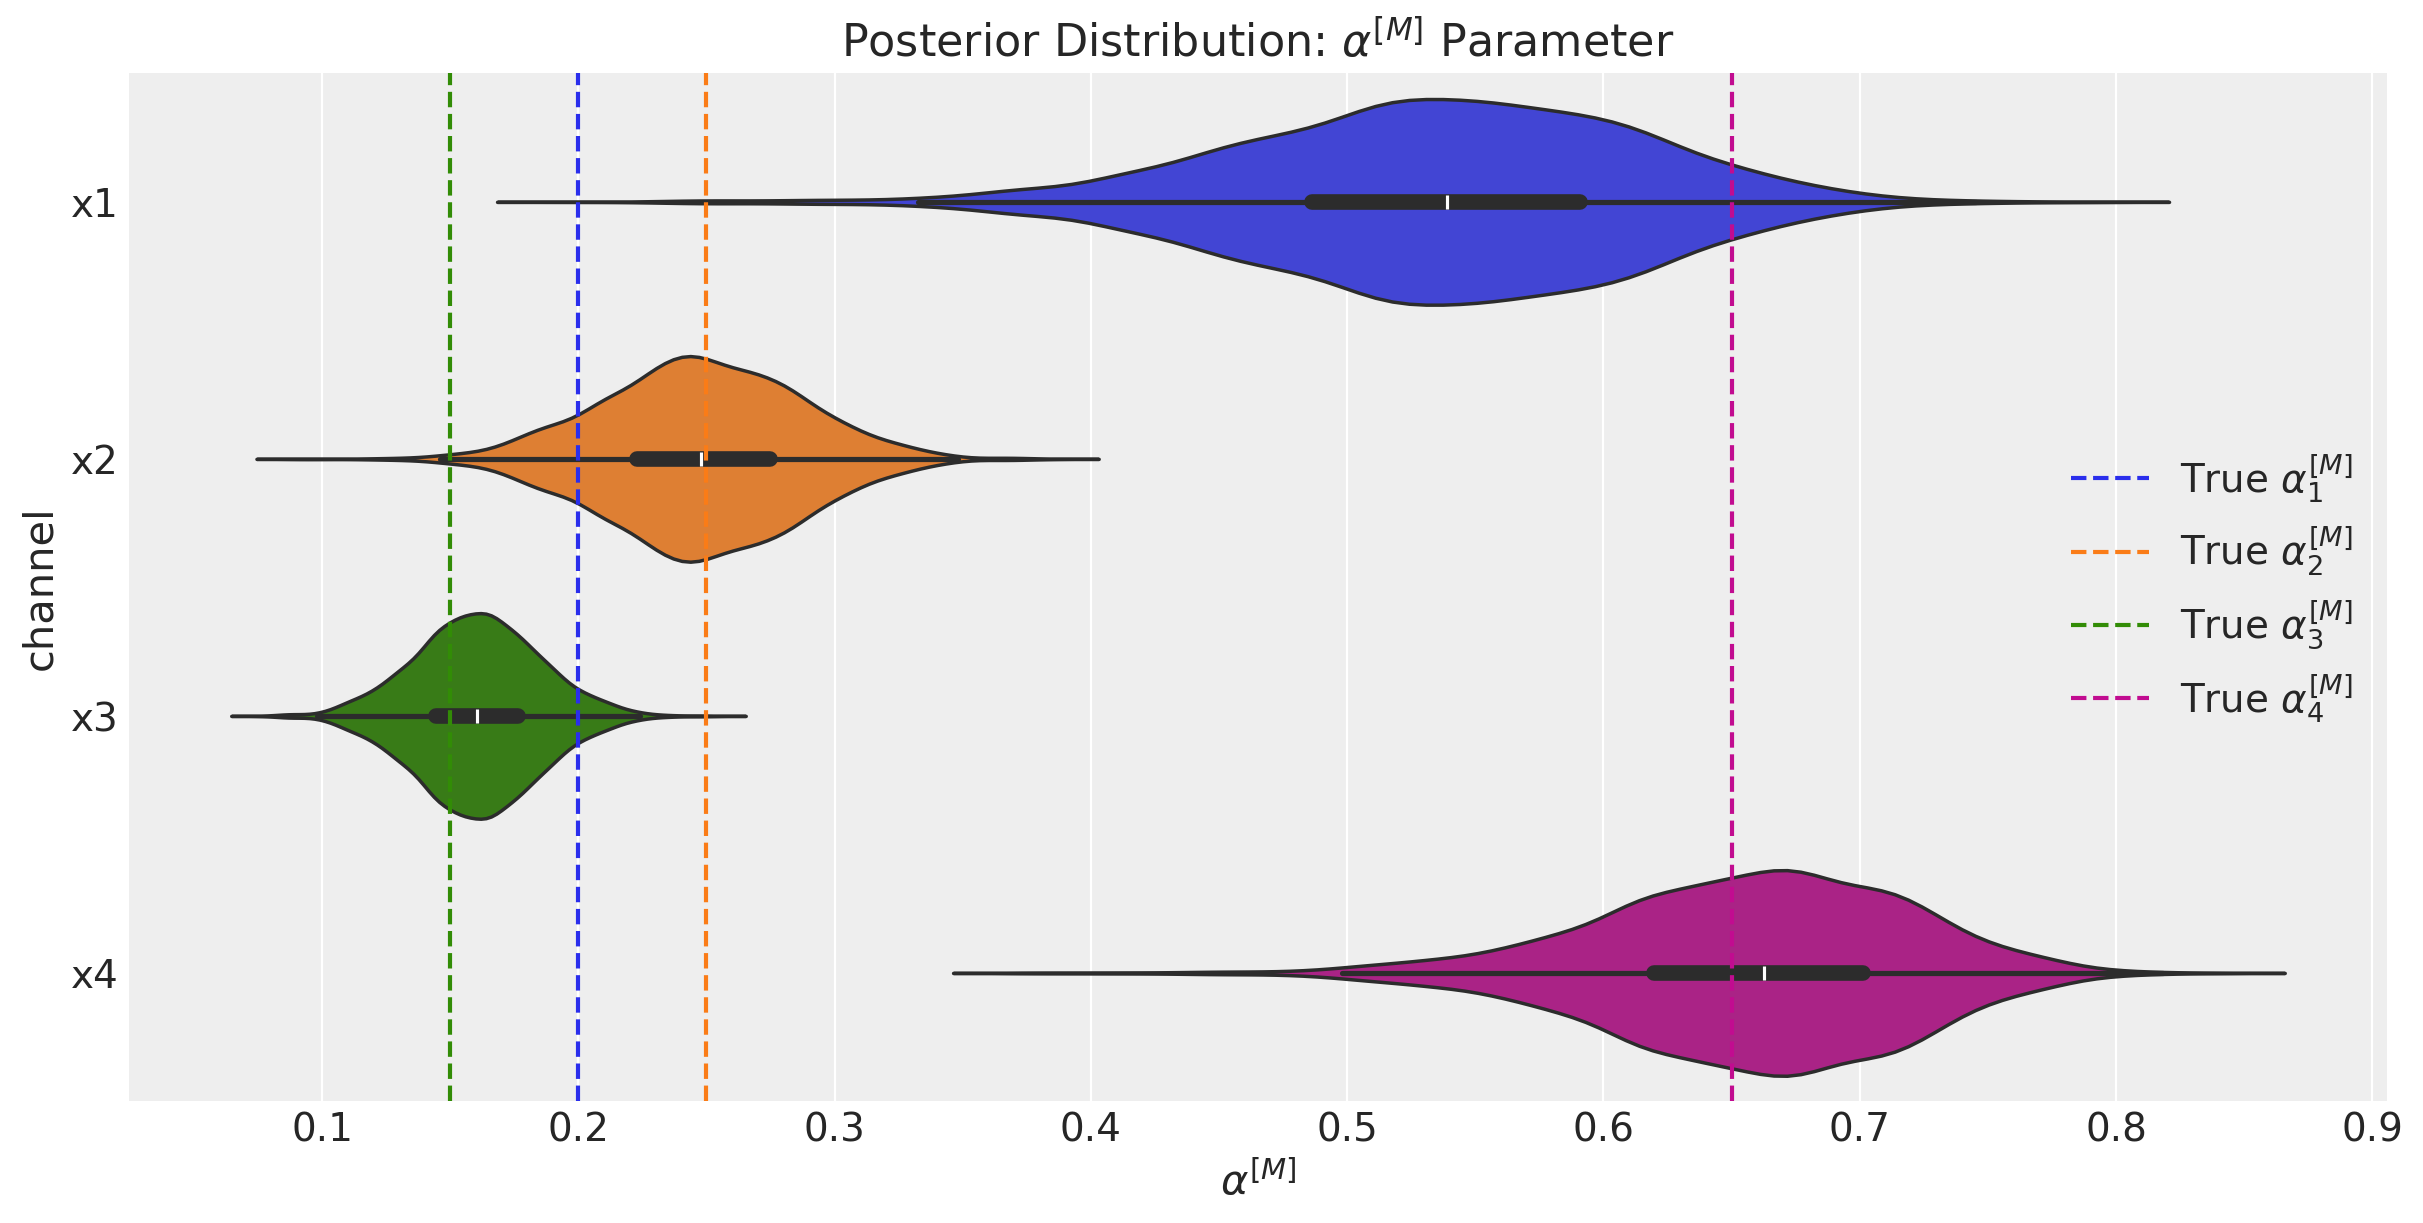

In [9]:
# True alphas
alpha1: float = 0.2
alpha2: float = 0.25
alpha3: float = 0.15
alpha4: float = 0.65

# Estimated alphas
alpha_m_samples_df = pd.DataFrame(data=az.extract(mmm.idata, var_names=['adstock_alpha']).T, columns = mmm.idata.posterior.channel)

fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(data=alpha_m_samples_df, orient="h", ax=ax)
ax.set(title=f"Posterior Distribution: {r"$\alpha^{[M]}$"} Parameter",xlabel=r"$\alpha^{[M]}$",ylabel="channel")
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"True $\alpha^{[M]}_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"True $\alpha^{[M]}_2$")
ax.axvline(x=alpha3, color="C2", linestyle="--", label=r"True $\alpha^{[M]}_3$")
ax.axvline(x=alpha4, color="C3", linestyle="--", label=r"True $\alpha^{[M]}_4$")
ax.legend()
plt.show()

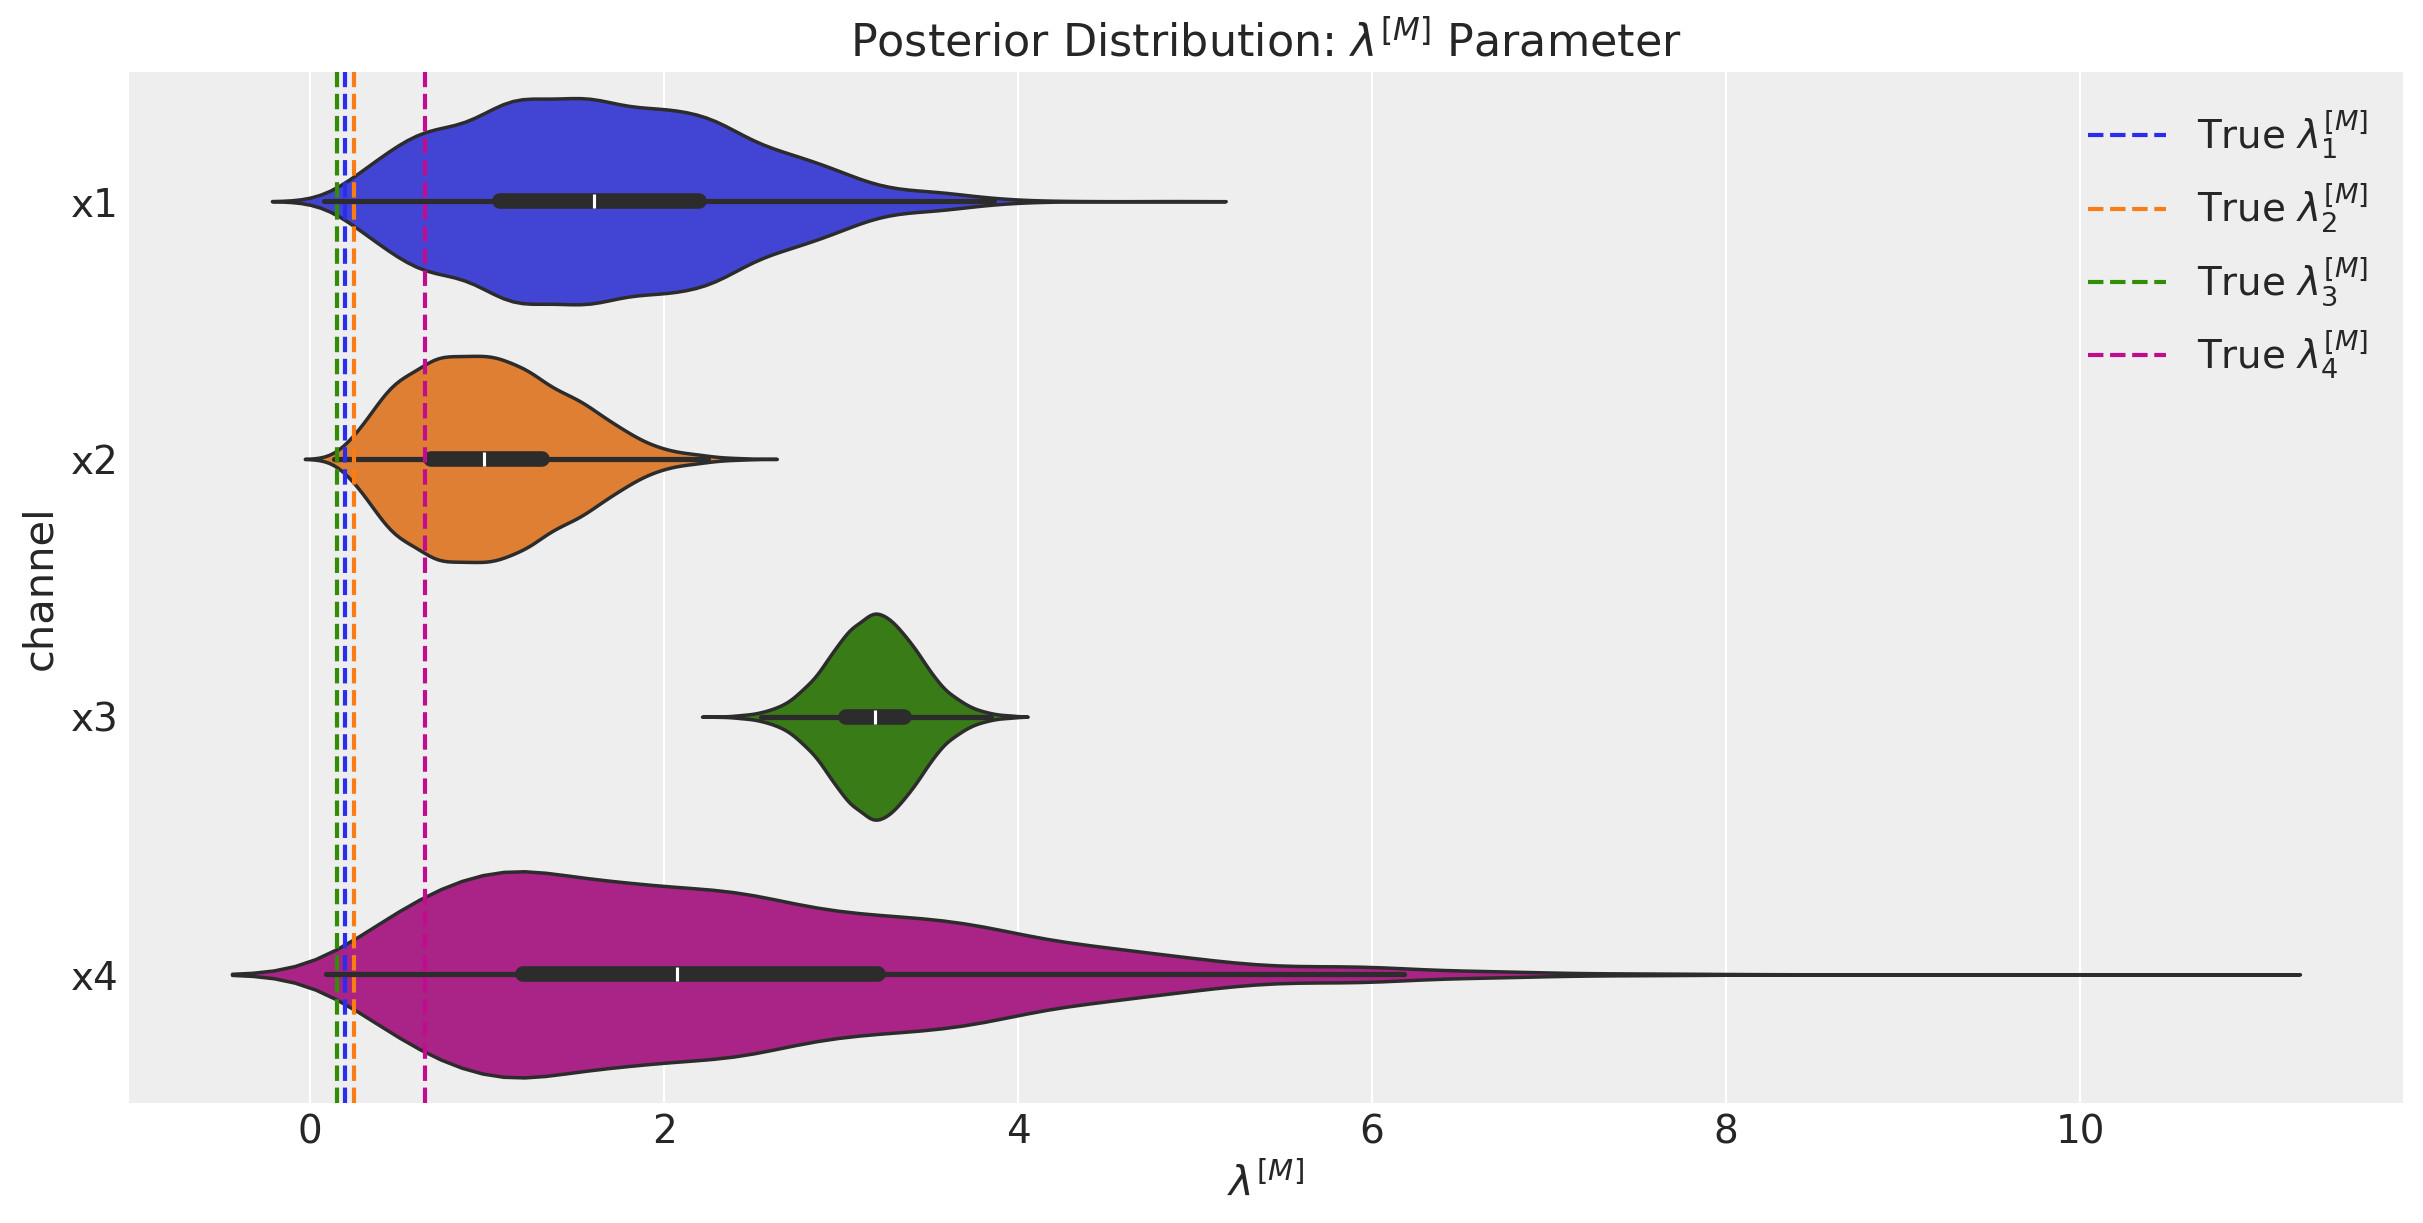

In [10]:
# True Lambdas
lam1: float = 1.5
lam2: float = 2.5
lam3: float = 2.0
lam4: float = 1.0

# Estimated lambdas
lam_m_samples_df = pd.DataFrame(data=az.extract(mmm.idata, var_names=['saturation_lam']).T, columns = mmm.idata.posterior.channel)

fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(data=lam_m_samples_df, orient="h", ax=ax)
ax.set(title=f"Posterior Distribution: {r"$\lambda^{[M]}$"} Parameter",xlabel=r"$\lambda^{[M]}$",ylabel="channel")
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"True $\lambda^{[M]}_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"True $\lambda^{[M]}_2$")
ax.axvline(x=alpha3, color="C2", linestyle="--", label=r"True $\lambda^{[M]}_3$")
ax.axvline(x=alpha4, color="C3", linestyle="--", label=r"True $\lambda^{[M]}_4$")
ax.legend()
plt.show()

### Insights recovery

- Contributions over time
- ROAS

**Note:** There is no functionality to extract the full sales attribution over time. You can extract channels and baseline, but to extract controls, you have to derive the contributions directly.

In [11]:
# Reading in true contributions
true_contributions = pd.read_csv("/Users/jakepiekarski/Documents/meridian-blog/true_contribution_data_over_time.csv")

In [12]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
).reset_index()

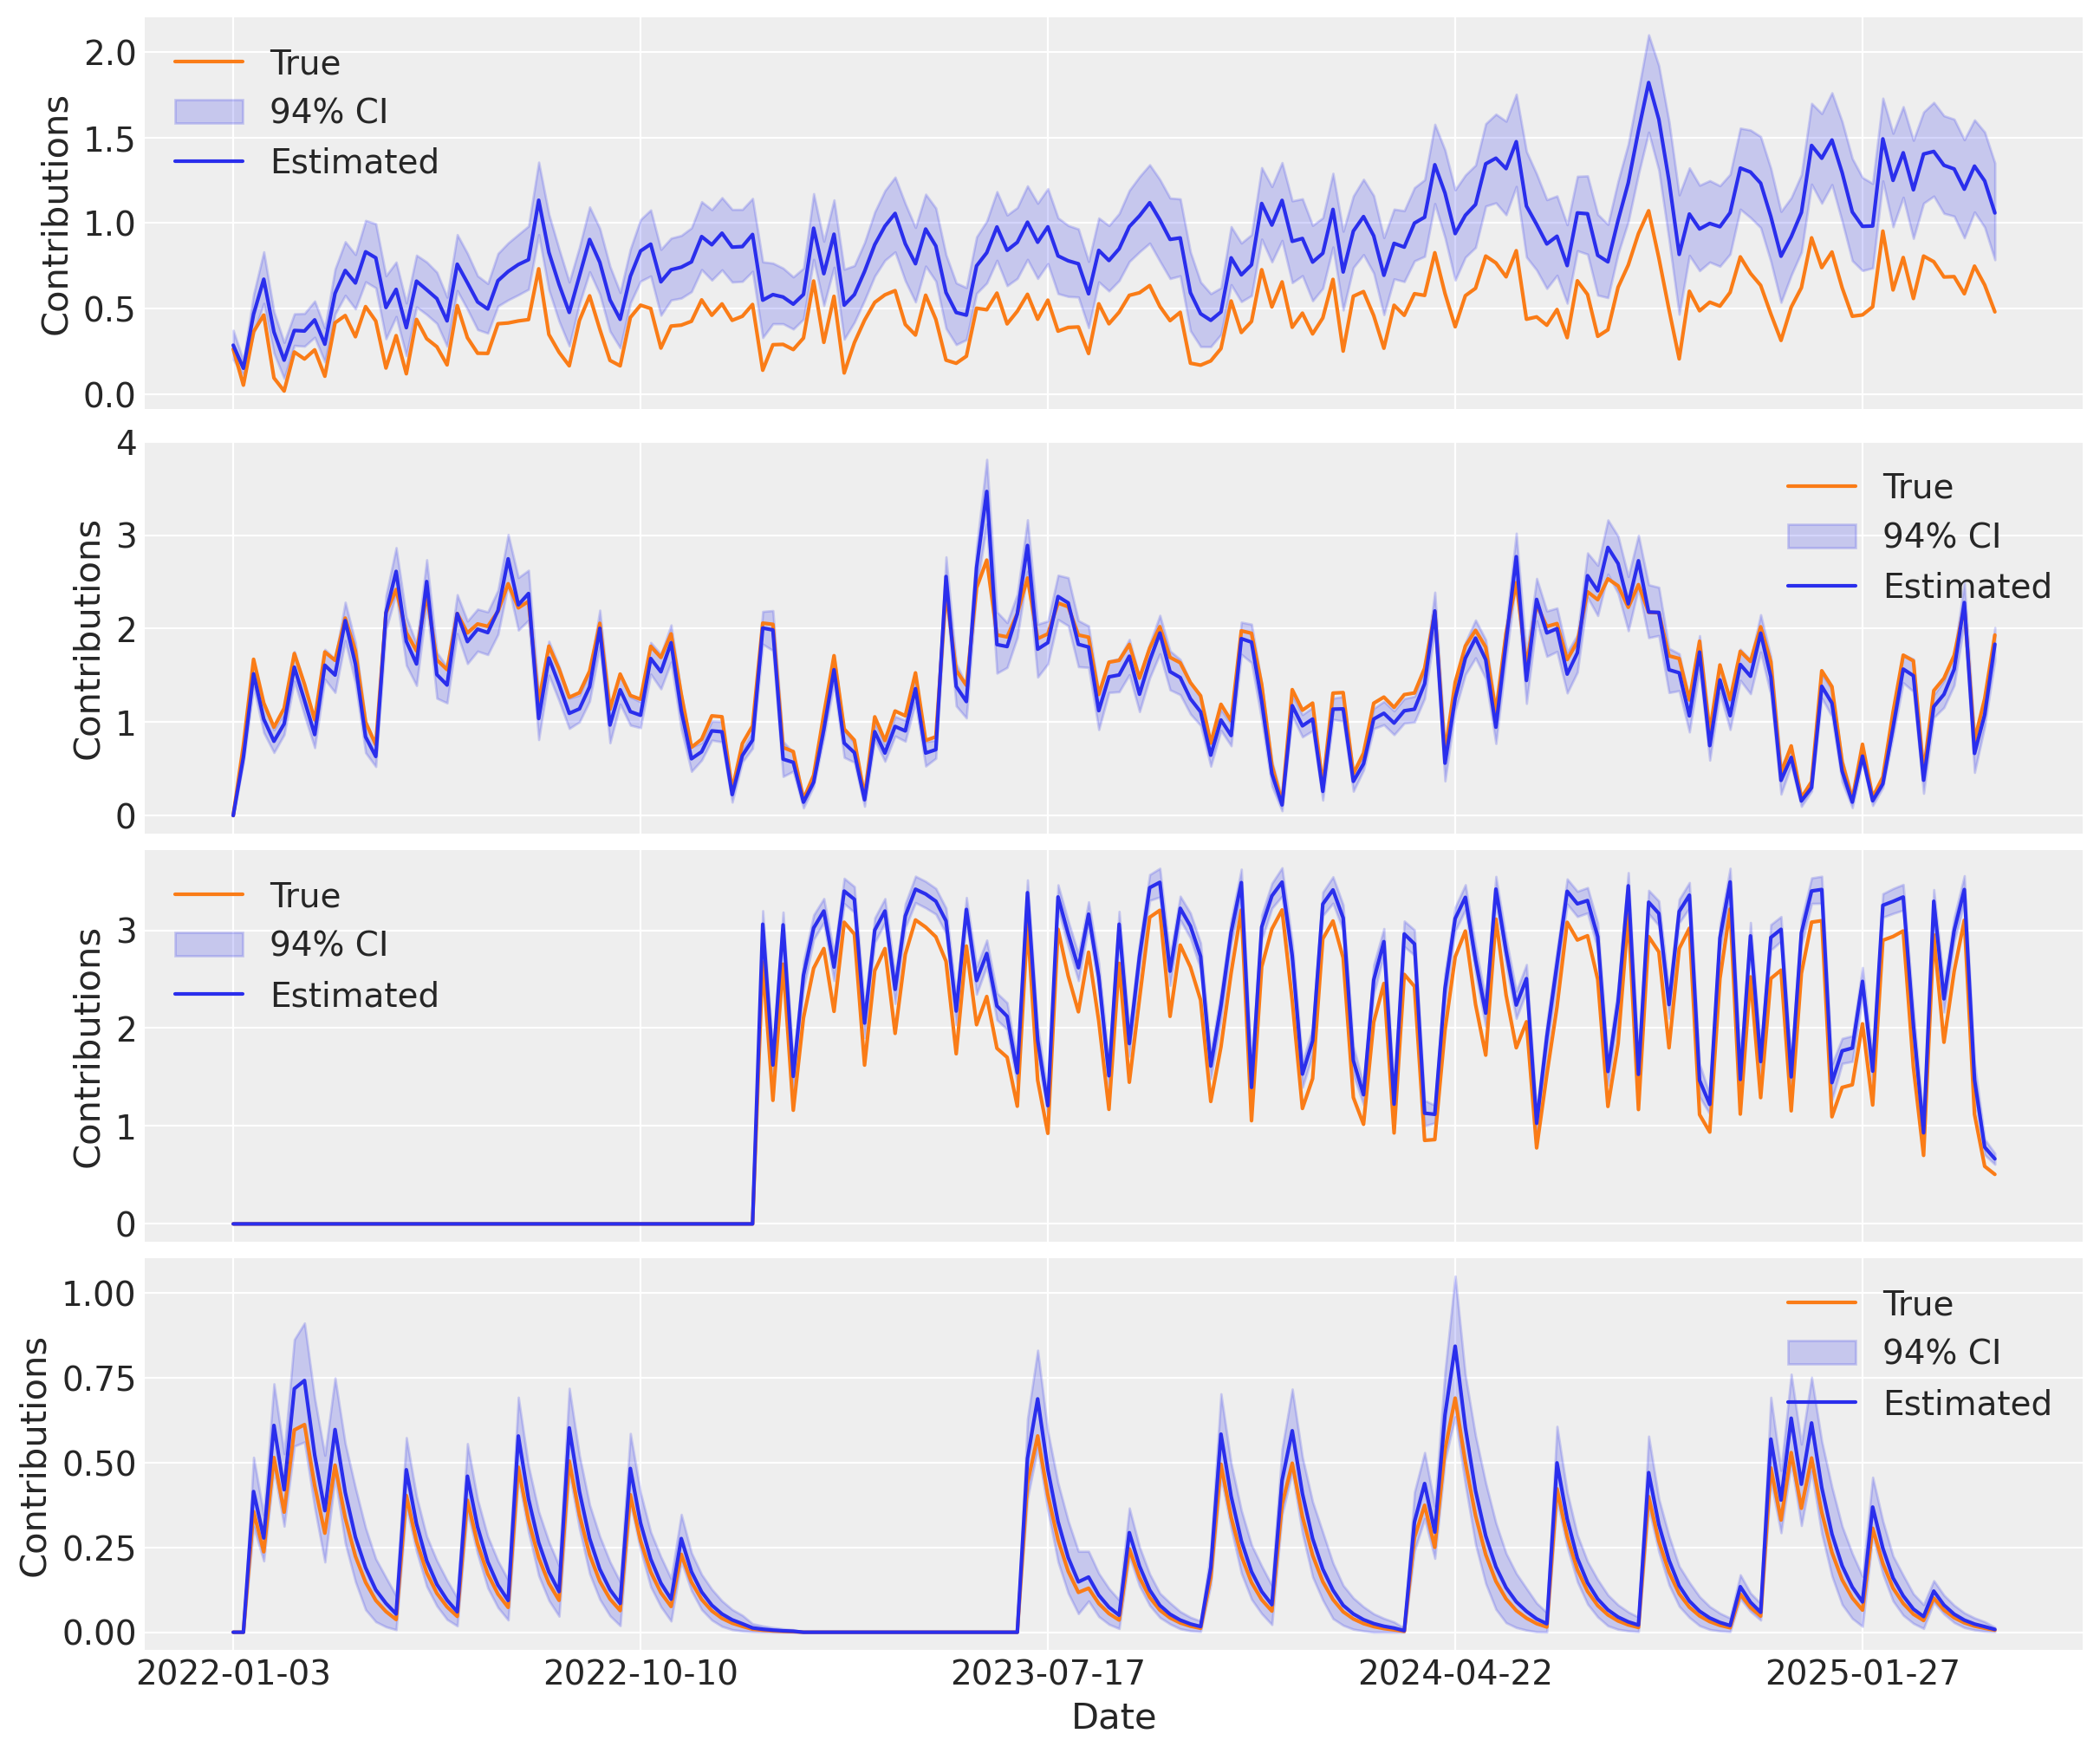

In [13]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=4, figsize=(12, 10), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2", "x3", "x4"]):
    # Estimate true contribution in the original scale from the data generating process
    sns.lineplot(
        x=true_contributions["date_week"],
        y=true_contributions[f"{x}_contribution"],
        color="C1",
        label="True",
        ax=ax[i],
    )
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=true_contributions["date_week"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color="C0", alpha=0.2, label="94% CI"
    )
    # Mean estimated contribution in the original scale
    sns.lineplot(
        x=true_contributions["date_week"],
        y=get_mean_contributions_over_time_df[x].to_numpy(),
        color = "C0",
        label="Estimated",
        alpha=1,
        ax=ax[i],
    )
    ax[i].legend()
    ax[i].set(xlabel="Date", ylabel="Contributions")
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))

In [14]:
true_contributions_renamed = true_contributions.rename(columns={
    "x1_contribution": "x1",
    "x2_contribution": "x2",
    "x3_contribution": "x3",
    "x4_contribution": "x4"
})

true_roas = true_contributions_renamed[["x1", "x2", "x3", "x4"]].sum()/data[["x1", "x2", "x3", "x4"]].sum()

In [15]:
estimated_roas = get_mean_contributions_over_time_df[['x1','x2','x3','x4']].sum()/data[["x1", "x2", "x3", "x4"]].sum()

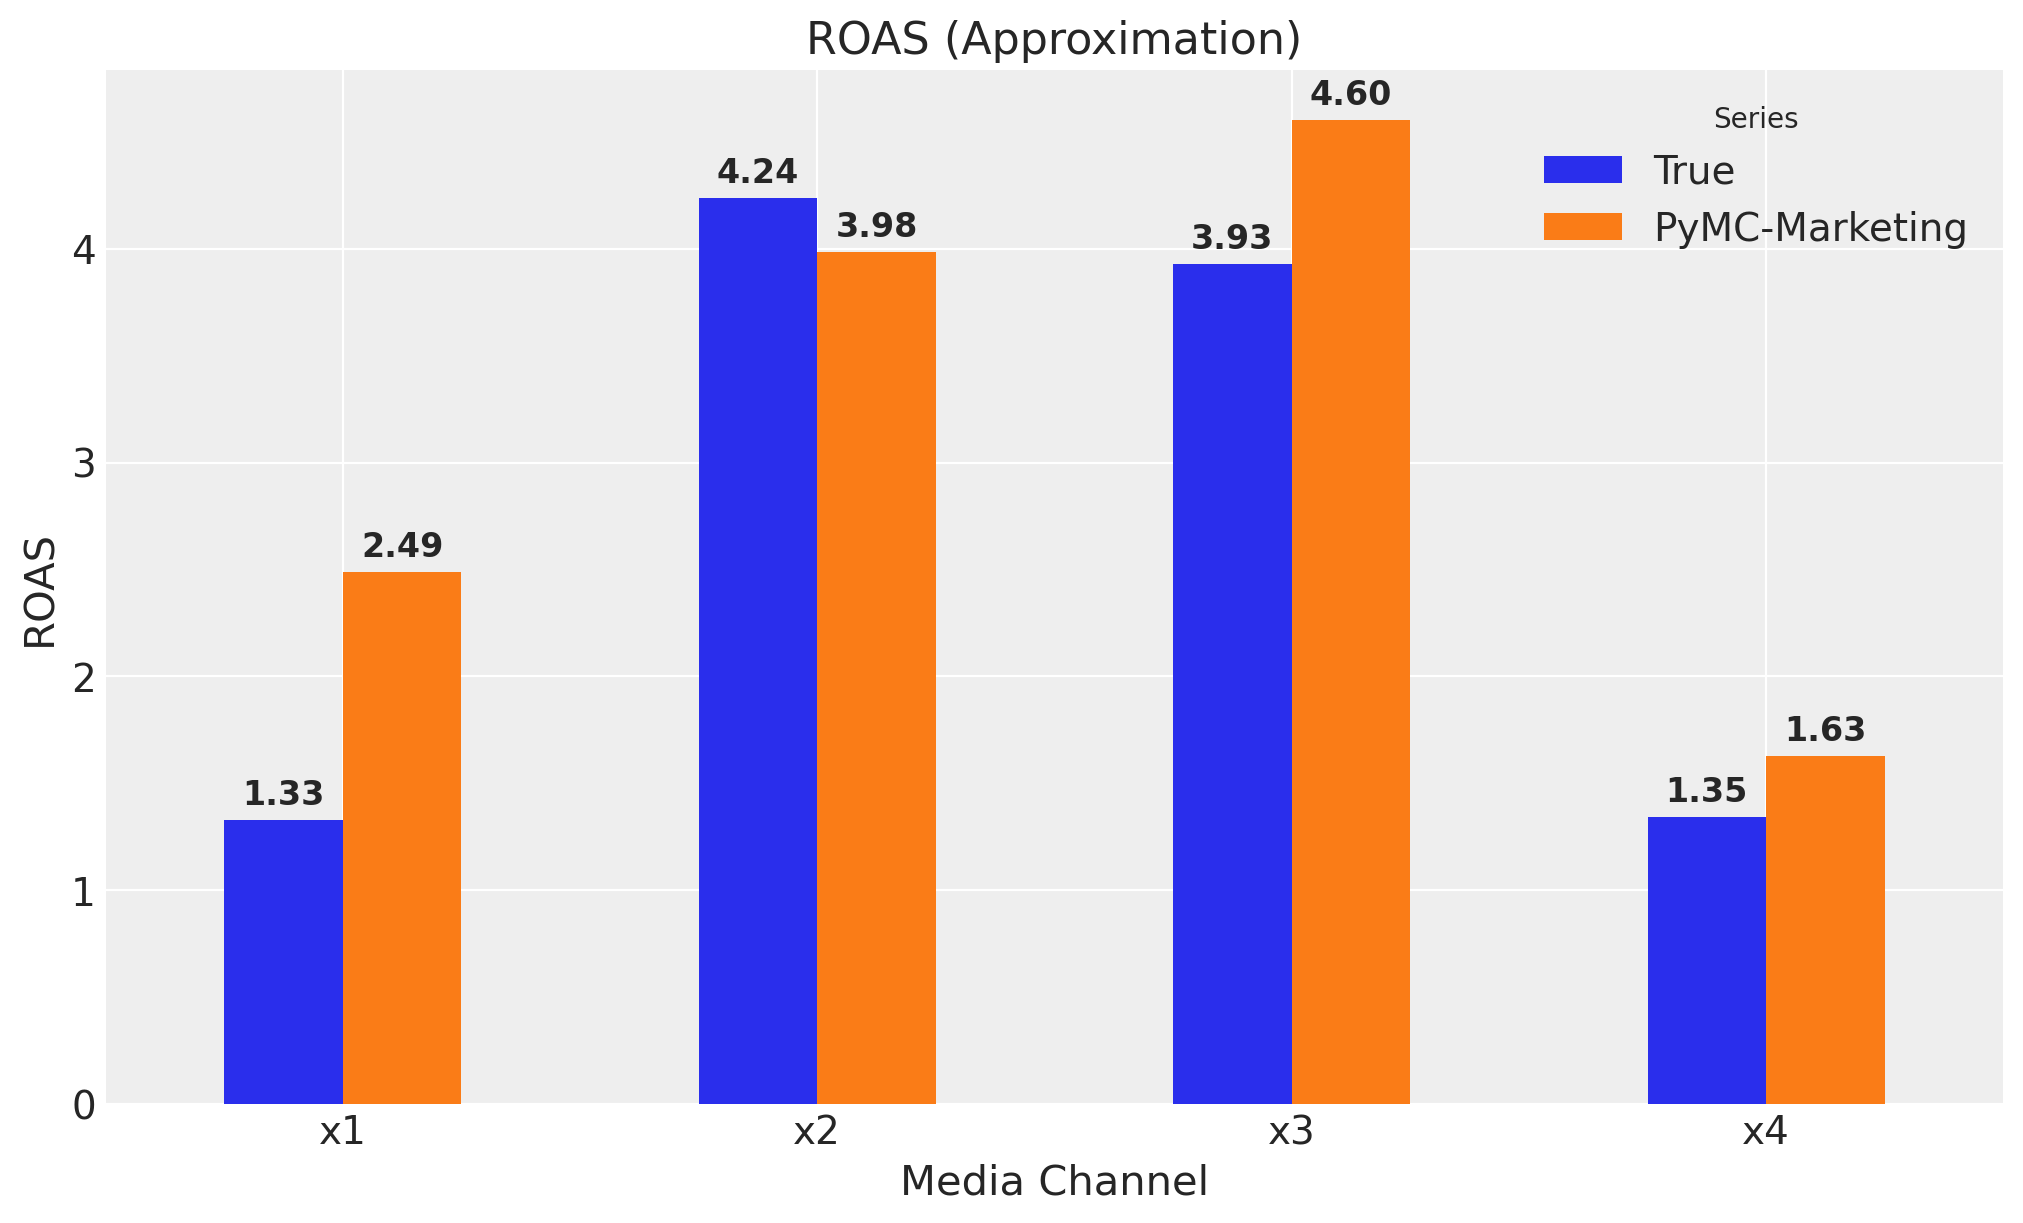

In [16]:
# Create DataFrame
roas = pd.DataFrame({"True": true_roas, "PyMC-Marketing": estimated_roas})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bar chart
roas.plot(kind="bar", ax=ax, color=["C0", "C1"])

# Add title and labels
ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS")

# Add values above bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12, fontweight="bold", padding=3)

# Show plot
plt.xticks(rotation=0)  # Ensure x-axis labels are readable
plt.legend(title="Series")
plt.show()